<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/DL-ML_ILUMINACION_VISION_COMPUTADORA/blob/main/Semana_11_v2_CON_TAREA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def collect_arrays(dataset):
    y_true, y_pred = [], []
    for batch_x, batch_y in dataset:
        y_true.append(batch_y.numpy())
    y_true = np.concatenate(y_true)
    return y_true

def eval_and_report(model, dataset, class_names, title="Evaluación"):
    # y_true
    y_true = collect_arrays(dataset)
    # y_pred
    y_prob = model.predict(dataset, verbose=0)
    y_pred = y_prob.argmax(1)

    print(f"== {title} ==")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap="Blues", cbar=True)
    plt.title(f"Matriz de confusión — {title}")
    plt.xlabel("Predicción"); plt.ylabel("Verdadero")
    plt.tight_layout(); plt.show()

def plot_history(h, title="Training"):
    plt.figure(figsize=(11,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title(f"{title} — Loss"); plt.legend(); plt.grid(True, alpha=0.3)
    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(h.history["accuracy"], label="train")
    plt.plot(h.history["val_accuracy"], label="val")
    plt.title(f"{title} — Accuracy"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def show_sample_predictions(model, dataset, class_names, k=12):
    images, labels = next(iter(dataset.unbatch().batch(k)))
    probs = model.predict(images, verbose=0)
    preds = probs.argmax(1)

    plt.figure(figsize=(14, 10))
    for i in range(k):
        plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy())
        t = class_names[int(labels[i].numpy())]
        p = class_names[int(preds[i])]
        ok = "✅" if t == p else "❌"
        plt.title(f"T:{t}\nP:{p} {ok}", fontsize=9)
        plt.axis("off")
    plt.suptitle("Muestras de validación — etiquetas vs predicción", y=1.02)
    plt.tight_layout(); plt.show()


In [ ]:
# Ajusta estos dos a lo que uses:
IMG_SIZE = (128, 128)   # puedes subir a (160,160) o (224,224) si tienes GPU potente
FLAT_DIM  = IMG_SIZE[0] * IMG_SIZE[1] * 3
TIMESTEPS = IMG_SIZE[0]
FEATURES  = IMG_SIZE[1] * 3
def show_sample_predictions_any(model, dataset_images, class_names, k=12, mode="cnn", kind=None):
    """
    mode: "cnn"  -> el modelo espera (B, H, W, 3)
          "mlp"  -> el modelo espera (B, H*W*3)
          "lstm" -> el modelo espera (B, H, W*3)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Tomamos k imágenes *del pipeline de imágenes* para visualizar
    imgs, labels = next(iter(dataset_images.unbatch().batch(k)))
    imgs_np = imgs.numpy()  # (k, H, W, 3)
    y_true  = labels.numpy()

    # Prepara X según el modelo
    if mode == "mlp":
        X = imgs_np.reshape((k, FLAT_DIM)).astype("float32")
    elif mode == "lstm":
        X = imgs_np.reshape((k, TIMESTEPS, FEATURES)).astype("float32")
    else:  # "cnn"
        X = imgs_np.astype("float32")

    # Predice
    probs = model.predict(X, verbose=0)
    y_pred = probs.argmax(1)

    # Muestra imágenes + etiquetas
    plt.figure(figsize=(14, 10))
    for i in range(k):
        plt.subplot(3, 4, i+1)
        plt.imshow(imgs_np[i])
        t = class_names[int(y_true[i])]
        p = class_names[int(y_pred[i])]
        ok = "✅" if t == p else "❌"
        plt.title(f"T:{t}\nP:{p} {ok}", fontsize=9)
        plt.axis("off")
    plt.suptitle("Muestras de validación — etiquetas vs predicción", y=1.02)
    plt.tight_layout(); plt.show()


In [ ]:
# === Setup & reproducibilidad ===
!pip -q install seaborn

import os, random, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print(tf.__version__)


2.19.0


In [ ]:
from google.colab import drive


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_drive_path = "/content/drive/MyDrive/A105 RECONOCIMIENTO DE FORMAS Y APRENDIZAJE COMPUTACIONAL /Clases/Semana 9/perros.zip"
dataset_extract_path = "/content/stanford_dogs"

# Crear carpeta de extracción
os.makedirs(dataset_extract_path, exist_ok=True)

# Descomprimir directamente desde Drive
with zipfile.ZipFile(zip_drive_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

print("Archivos extraídos en:", dataset_extract_path)
!ls "/content/stanford_dogs"


Archivos extraídos en: /content/stanford_dogs
annotations  images


In [ ]:
# === Parámetros generales ===
BATCH    = 32
DATA_DIR = "/content/stanford_dogs/images/Images"  # <-- AJUSTA A TU RUTA

# === Carga dataset desde carpeta ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Clases:", NUM_CLASSES)
print(class_names[:10])


Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Clases: 120
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']


In [ ]:
# === Normalización y performance (para imágenes tal cual) ===
AUTOTUNE = tf.data.AUTOTUNE

def norm_map(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_img = train_ds.map(norm_map, num_parallel_calls=AUTOTUNE)\
                    .cache()\
                    .shuffle(2048, seed=SEED, reshuffle_each_iteration=True)\
                    .prefetch(AUTOTUNE)

val_img   = val_ds.map(norm_map, num_parallel_calls=AUTOTUNE)\
                  .cache()\
                  .prefetch(AUTOTUNE)


def to_mlp(img, label):                  # (H,W,3) -> (H*W*3,)
    x = tf.reshape(img, [IMG_SIZE[0]*IMG_SIZE[1]*3])
    return x, label

def to_lstm(img, label):                 # (H,W,3) -> (H, W*3)
    x = tf.reshape(img, [TIMESTEPS, FEATURES])
    return x, label

ds_mlp_train  = train_img.map(to_mlp,  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_mlp_val    = val_img.map(to_mlp,    num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

ds_lstm_train = train_img.map(to_lstm, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_lstm_val   = val_img.map(to_lstm,   num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


In [ ]:
# === Callbacks comunes ===
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5),
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True),
]


Model: "mlp_flat"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mlp_input (InputLayer)          │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,346,040 (96.69 MB)

 Trainable params: 25,346,040 (96.69 MB)

 Non-trainable params: 0 (0.00 B)

48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 662ms/step - accuracy: 0.0113 - loss: 10.2033 - val_accuracy: 0.0098 - val_loss: 4.7862 - learning_rate: 0.0010


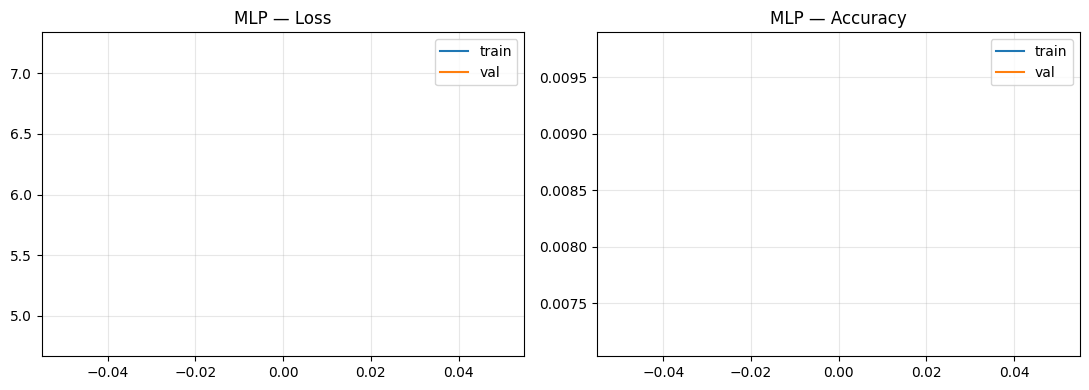

== MLP (val) ==
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua      0.000     0.000     0.000        26
              n02085782-Japanese_spaniel      0.000     0.000     0.000        43
                   n02085936-Maltese_dog      0.000     0.000     0.000        48
                      n02086079-Pekinese      0.000     0.000     0.000        30
                      n02086240-Shih-Tzu      0.000     0.000     0.000        45
              n02086646-Blenheim_spaniel      0.000     0.000     0.000        39
                      n02086910-papillon      0.000     0.000     0.000        38
                   n02087046-toy_terrier      0.000     0.000     0.000        25
           n02087394-Rhodesian_ridgeback      0.000     0.000     0.000        37
                  n02088094-Afghan_hound      0.000     0.000     0.000        56
                        n02088238-basset      0.000     0.000     0.000        39

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


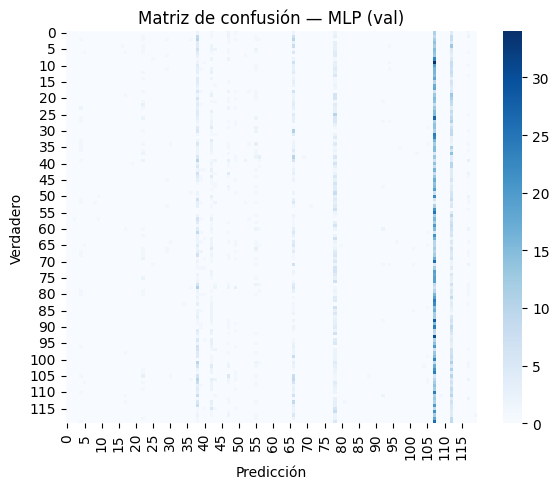

/tmp/ipython-input-2279602758.py:43: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-2279602758.py:43: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


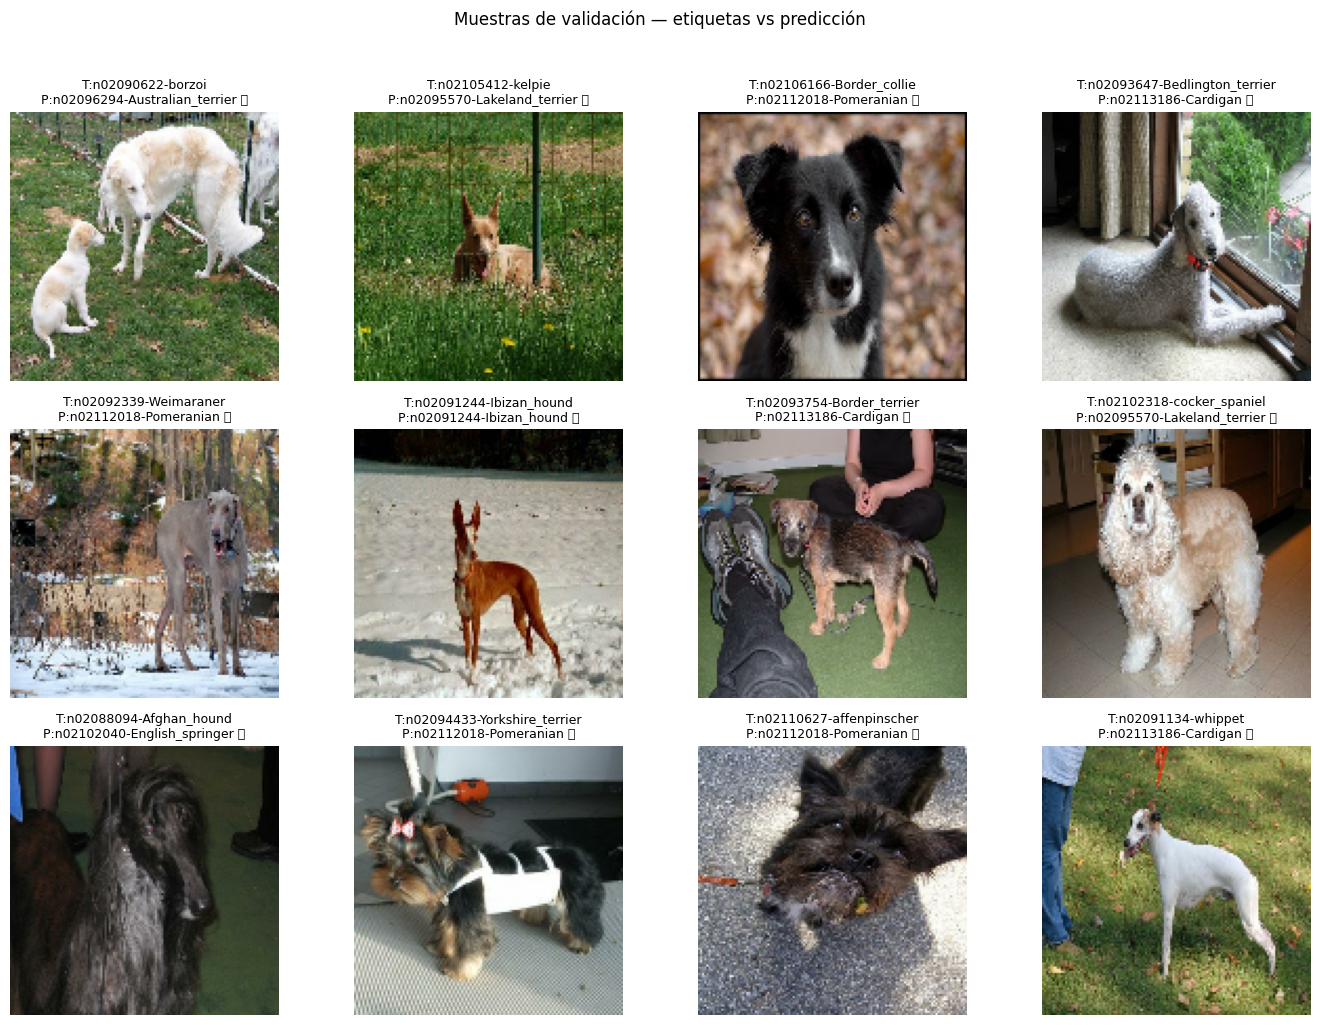

In [ ]:
def build_mlp(input_dim, num_classes):
    inp = keras.Input(shape=(input_dim,), name="mlp_input")
    x = layers.Dense(512, activation="relu")(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out, name="mlp_flat")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

mlp_model = build_mlp(IMG_SIZE[0]*IMG_SIZE[1]*3, NUM_CLASSES)
mlp_model.summary()

history_mlp = mlp_model.fit(
    ds_mlp_train,
    validation_data=ds_mlp_val,
    epochs=1,
    callbacks=cbs,
    verbose=1,
    steps_per_epoch=48,
    validation_steps=16
)

plot_history(history_mlp, "MLP")
eval_and_report(mlp_model, ds_mlp_val, class_names, title="MLP (val)")
show_sample_predictions_any(mlp_model, val_img, class_names, k=12, mode="mlp")


Model: "rnn_on_rows"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_sequence        │ (None, 128, 384)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 128, 384)  │          0 │ img_sequence[0][… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 128, 384)  │          0 │ img_sequence[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 128)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    229,888 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 120)       │      7,800 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 245,944 (960.72 KB)

 Trainable params: 245,944 (960.72 KB)

 Non-trainable params: 0 (0.00 B)

48/48 ━━━━━━━━━━━━━━━━━━━━ 27s 388ms/step - accuracy: 0.0117 - loss: 4.8130 - val_accuracy: 0.0098 - val_loss: 4.7922 - learning_rate: 0.0010


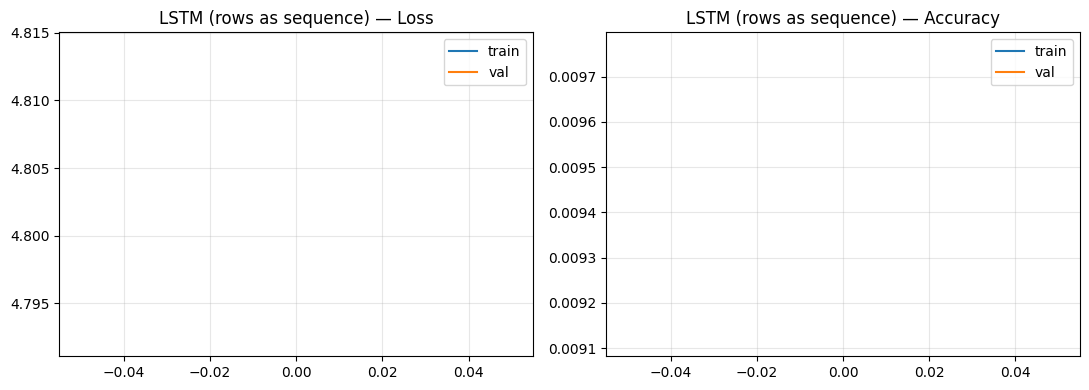

== LSTM (val) ==
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua      0.011     0.038     0.018        26
              n02085782-Japanese_spaniel      0.000     0.000     0.000        43
                   n02085936-Maltese_dog      0.012     0.312     0.023        48
                      n02086079-Pekinese      0.000     0.000     0.000        30
                      n02086240-Shih-Tzu      0.000     0.000     0.000        45
              n02086646-Blenheim_spaniel      0.000     0.000     0.000        39
                      n02086910-papillon      0.000     0.000     0.000        38
                   n02087046-toy_terrier      0.000     0.000     0.000        25
           n02087394-Rhodesian_ridgeback      0.000     0.000     0.000        37
                  n02088094-Afghan_hound      0.000     0.000     0.000        56
                        n02088238-basset      0.000     0.000     0.000        3

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


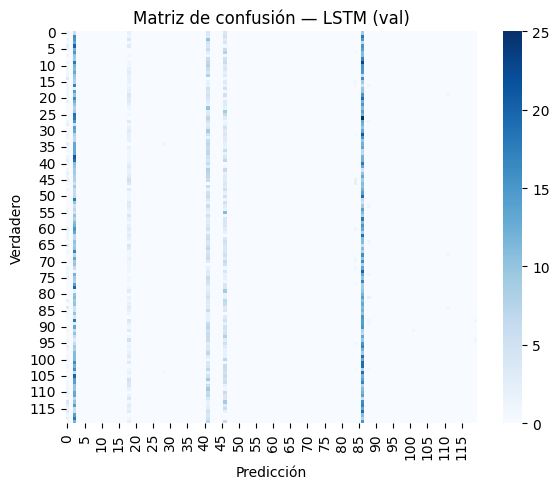

/tmp/ipython-input-2279602758.py:43: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


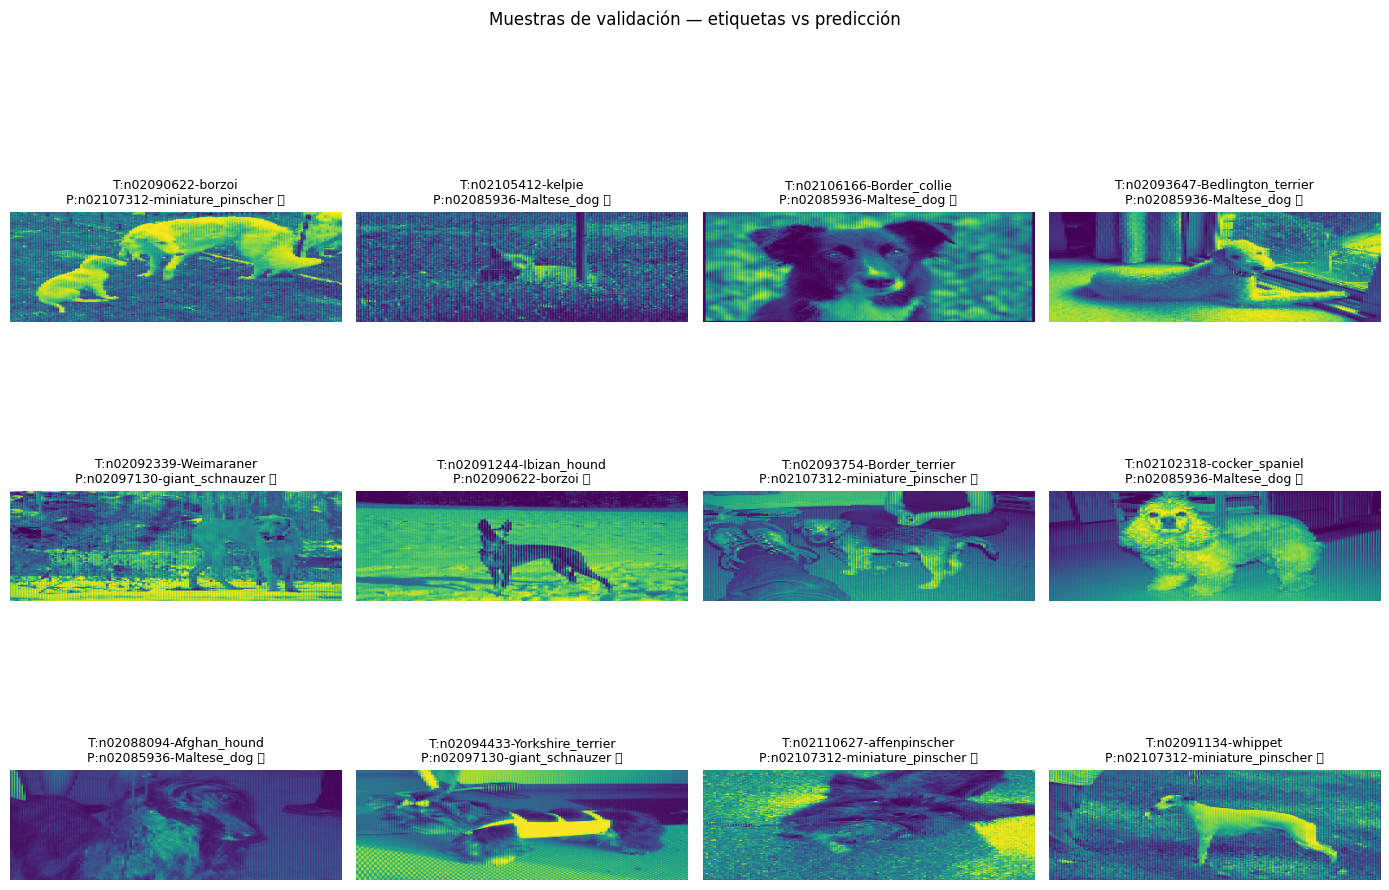

In [ ]:
def build_lstm(timesteps, features, num_classes):
    inputs = keras.Input(shape=(timesteps, features), name="img_sequence")
    x = layers.Masking(mask_value=0.0)(inputs)  # opcional
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="rnn_on_rows")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return model

lstm_model = build_lstm(TIMESTEPS, FEATURES, NUM_CLASSES)
lstm_model.summary()

# Entrenamiento
history_lstm = lstm_model.fit(
    ds_lstm_train,
    validation_data=ds_lstm_val,
    epochs=1,
    callbacks=cbs,
    verbose=1,
    steps_per_epoch=48,
    validation_steps=16
)

plot_history(history_lstm, "LSTM (rows as sequence)")
eval_and_report(lstm_model, ds_lstm_val, class_names, title="LSTM (val)")

# ✅ Para LSTM, muestra predicciones a partir del dataset 3D (ya mapeado)
show_sample_predictions_any(lstm_model, ds_lstm_val, class_names, k=12, kind="lstm")



Model: "cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,728 (424.72 KB)

 Trainable params: 108,728 (424.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.0095 - loss: 4.7906 - val_accuracy: 0.0078 - val_loss: 4.7883 - learning_rate: 0.0010
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.0116 - loss: 4.7878 - val_accuracy: 0.0078 - val_loss: 4.7840 - learning_rate: 0.0010
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.0090 - loss: 4.7887 - val_accuracy: 0.0039 - val_loss: 4.7864 - learning_rate: 0.0010
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.0114 - loss: 4.7865 - val_accuracy: 0.0078 - val_loss: 4.7872 - learning_rate: 0.0010
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.0092 - loss: 4.7844 - val_accuracy: 0.0078 - val_loss: 4.7872 - learning_rate: 5.0000e-04


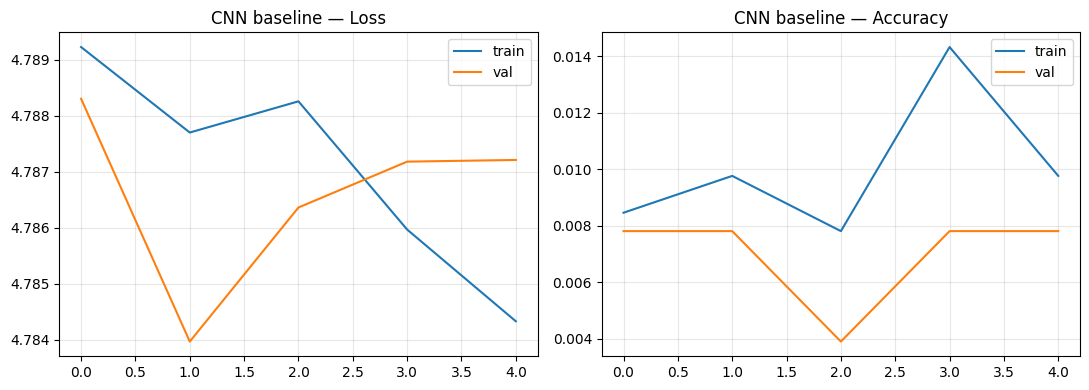

== CNN baseline (val) ==
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua      0.000     0.000     0.000        26
              n02085782-Japanese_spaniel      0.000     0.000     0.000        43
                   n02085936-Maltese_dog      0.012     1.000     0.023        48
                      n02086079-Pekinese      0.000     0.000     0.000        30
                      n02086240-Shih-Tzu      0.000     0.000     0.000        45
              n02086646-Blenheim_spaniel      0.000     0.000     0.000        39
                      n02086910-papillon      0.000     0.000     0.000        38
                   n02087046-toy_terrier      0.000     0.000     0.000        25
           n02087394-Rhodesian_ridgeback      0.000     0.000     0.000        37
                  n02088094-Afghan_hound      0.000     0.000     0.000        56
                        n02088238-basset      0.000     0.000     0.000 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


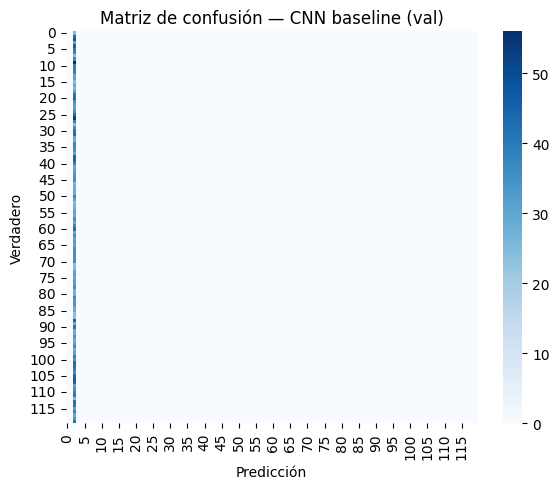

/tmp/ipython-input-1257084196.py:56: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


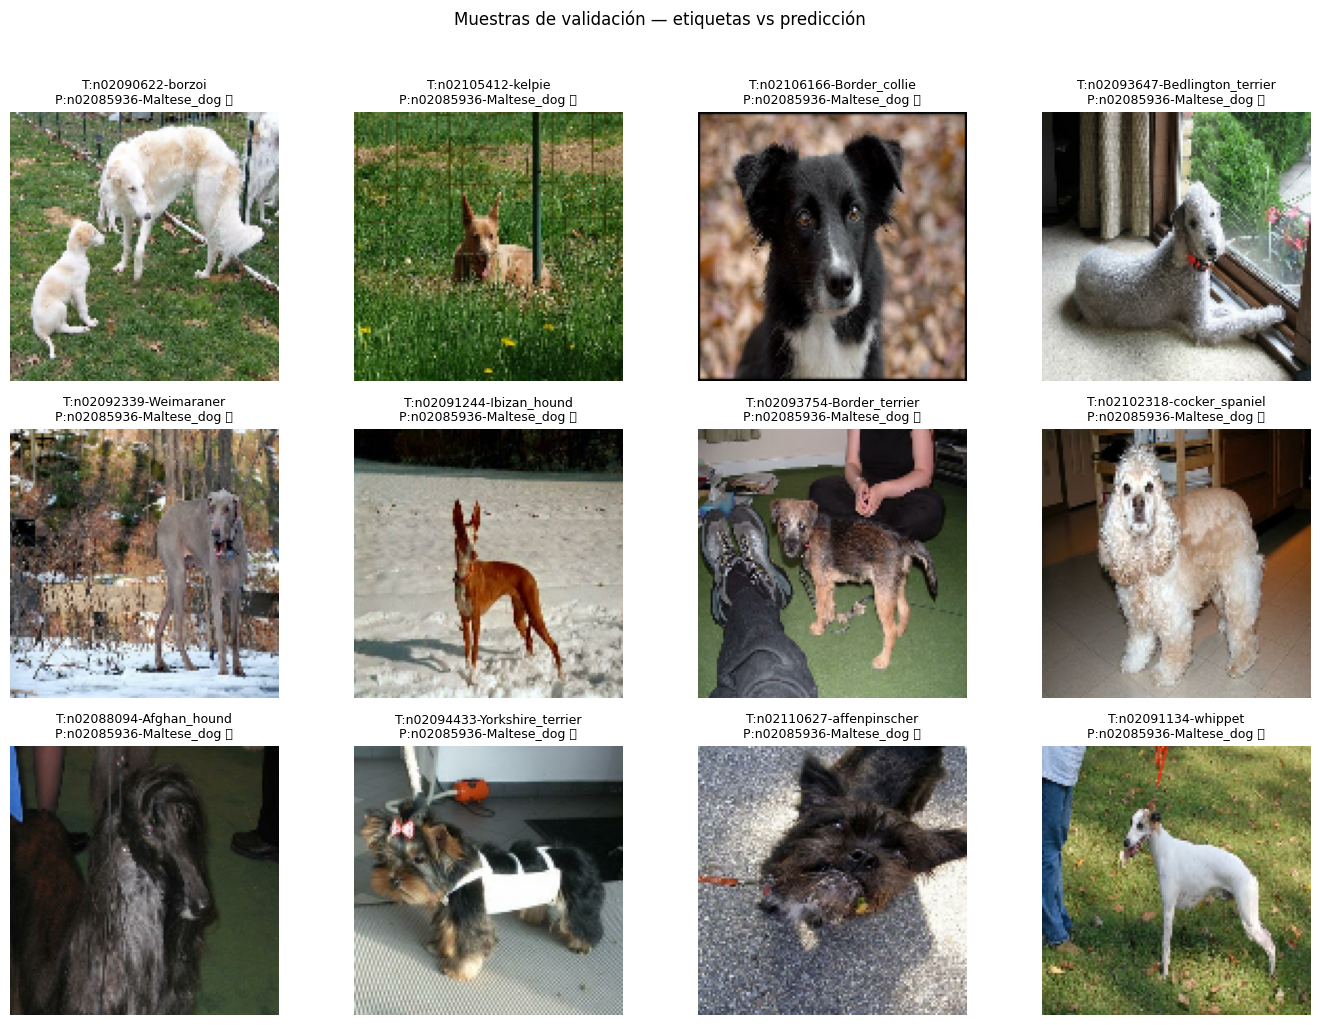

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_cnn(num_classes):
    inp = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out, name="cnn_baseline")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

RUN_CNN  = False
RUN_MLP  = True
RUN_LSTM = True
RUN_TL   = False  # transfer learning

cnn_model = build_cnn(NUM_CLASSES)
cnn_model.summary()

history_cnn = cnn_model.fit(
    train_img,
    validation_data=val_img,
    epochs=5,
    callbacks=cbs,
    verbose=1,
    steps_per_epoch=48,
    validation_steps=16
)

plot_history(history_cnn, "CNN baseline")
eval_and_report(cnn_model, val_img, class_names, title="CNN baseline (val)")
show_sample_predictions(cnn_model, val_img, class_names, k=12)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
=== Fase 1: Transfer Learning (base congelada) ===
Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 664ms/step - accuracy: 0.0826 - loss: 4.7057 - val_accuracy: 0.4023 - val_loss: 2.4866 - learning_rate: 0.0010
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 32s 673ms/step - accuracy: 0.4443 - loss: 2.2441 - val_accuracy: 0.5801 - val_loss: 1.5544 - learning_rate: 0.0010
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 30s 626ms/step - accuracy: 0.5733 - loss: 1.5275 - val_accuracy: 0.6426 - val_loss: 1.3227 - learning_rate: 0.0010
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 42s 892ms/step - accuracy: 0.6522 - loss: 1.3187 - val_accuracy: 0.6484 - val_loss: 1.1853 - learning_rate: 0.0010
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 33s 699ms/step - accuracy: 0.6644 - loss: 1.2025 - val_accuracy: 0.6777 - val_loss: 1.1324 - learning_rate: 0.0010
=== Fase 2: Fine-tuning (últimas capas) ===
Epoch 1/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 940ms/step - accuracy: 0.6749 - loss: 1.1498 - val_accu

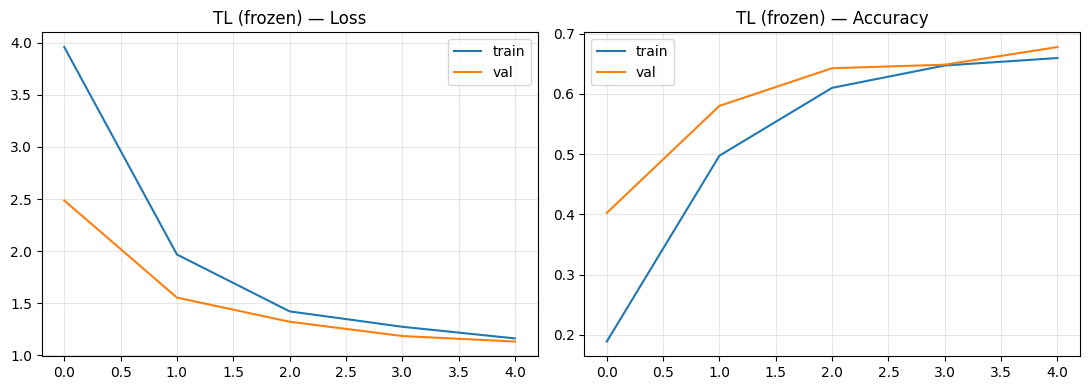

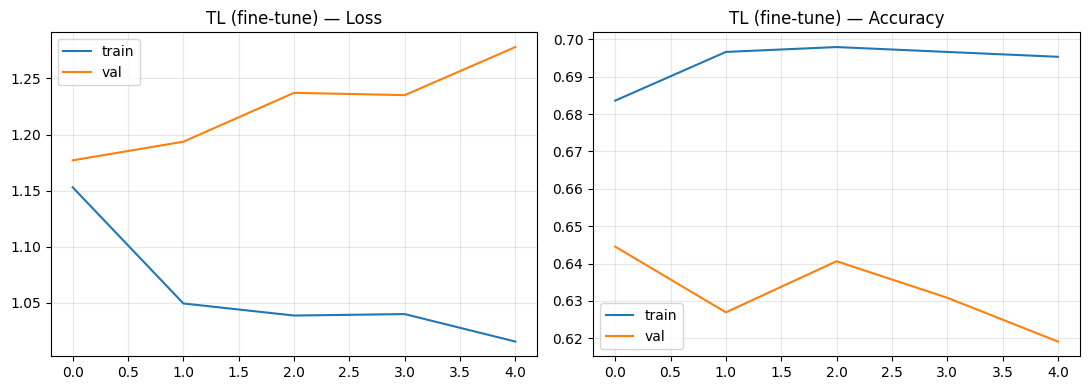

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Parámetros de corrida
# =========================
TRAIN_STEPS = 48
VAL_STEPS   = 16
FREEZE_EPOCHS = 5
FINETUNE_EPOCHS = 5
FINE_TUNE_LAST_N = 40   # descongelar últimas N capas

# =========================
# Utilidades de datasets
# =========================
def ensure_prefetch(ds):
    """Agrega prefetch si no existe (idempotente)."""
    return ds.prefetch(tf.data.AUTOTUNE)

def make_capped_datasets_take(train_ds, val_ds, train_steps=48, val_steps=16):
    """Limita cada época usando .take() (cada elemento ya es un batch)."""
    train_small = train_ds.take(train_steps)
    val_small   = val_ds.take(val_steps)
    return ensure_prefetch(train_small), ensure_prefetch(val_small)

def make_repeat_loops(train_ds, val_ds):
    """Prepara datasets infinitos (para usar steps_per_epoch)."""
    train_loop = train_ds.repeat().prefetch(tf.data.AUTOTUNE)
    val_loop   = val_ds.repeat().prefetch(tf.data.AUTOTUNE)
    return train_loop, val_loop

# =========================
# Modelo TL con MobileNetV2
# =========================
def build_tl_mobilenet_v2(img_size, num_classes):
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        input_shape=(img_size[0], img_size[1], 3),
        weights="imagenet"
    )
    base.trainable = False

    inputs = keras.Input(shape=(img_size[0], img_size[1], 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)  # escala a [-1, 1]
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="tl_mobilenetv2")

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model, base

def fine_tune_last_n_layers(model, base, last_n=40, lr=1e-4):
    base.trainable = True
    fine_tune_at = max(0, len(base.layers) - last_n)
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

# =========================
# Entrenamiento
# =========================
def train_tl_with_take(train_ds, val_ds, img_size, num_classes,
                       train_steps=48, val_steps=16,
                       freeze_epochs=5, finetune_epochs=5, last_n=40, cbs=None):
    """Modo simple: usa .take() para limitar batches/época."""
    train_small, val_small = make_capped_datasets_take(train_ds, val_ds, train_steps, val_steps)
    model, base = build_tl_mobilenet_v2(img_size, num_classes)

    print("=== Fase 1: Transfer Learning (base congelada) ===")
    hist_tl = model.fit(
        train_small,
        validation_data=val_small,
        epochs=freeze_epochs,
        callbacks=cbs
    )

    print("=== Fase 2: Fine-tuning (últimas capas) ===")
    fine_tune_last_n_layers(model, base, last_n=last_n, lr=1e-4)
    hist_ft = model.fit(
        train_small,
        validation_data=val_small,
        epochs=finetune_epochs,
        callbacks=cbs
    )
    return model, hist_tl, hist_ft

def train_tl_with_steps(train_ds, val_ds, img_size, num_classes,
                        train_steps=48, val_steps=16,
                        freeze_epochs=5, finetune_epochs=5, last_n=40, cbs=None):
    """Modo flexible: usa steps_per_epoch + .repeat()."""
    train_loop, val_loop = make_repeat_loops(train_ds, val_ds)
    model, base = build_tl_mobilenet_v2(img_size, num_classes)

    print("=== Fase 1: Transfer Learning (base congelada) ===")
    hist_tl = model.fit(
        train_loop,
        validation_data=val_loop,
        epochs=freeze_epochs,
        callbacks=cbs,
        steps_per_epoch=train_steps,
        validation_steps=val_steps
    )

    print("=== Fase 2: Fine-tuning (últimas capas) ===")
    fine_tune_last_n_layers(model, base, last_n=last_n, lr=1e-4)
    hist_ft = model.fit(
        train_loop,
        validation_data=val_loop,
        epochs=finetune_epochs,
        callbacks=cbs,
        steps_per_epoch=train_steps,
        validation_steps=val_steps
    )
    return model, hist_tl, hist_ft


model_tl, hist_tl, hist_ft = train_tl_with_steps(
    train_ds, val_ds,
    IMG_SIZE, NUM_CLASSES,
    train_steps=TRAIN_STEPS, val_steps=VAL_STEPS,
    freeze_epochs=FREEZE_EPOCHS, finetune_epochs=FINETUNE_EPOCHS,
    last_n=FINE_TUNE_LAST_N, cbs=cbs
)

# =========================
# Post-proceso / Evaluación
# =========================
plot_history(hist_tl, "TL (frozen)")
plot_history(hist_ft, "TL (fine-tune)")

# Si tienes a mano un batch 4D de validación (val_img) para mostrar ejemplos:
# eval_and_report(model_tl, val_img, class_names, title="Transfer Learning FT (val)")
# show_sample_predictions(model_tl, val_img, class_names, k=12)


/tmp/ipython-input-2698805443.py:21: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()


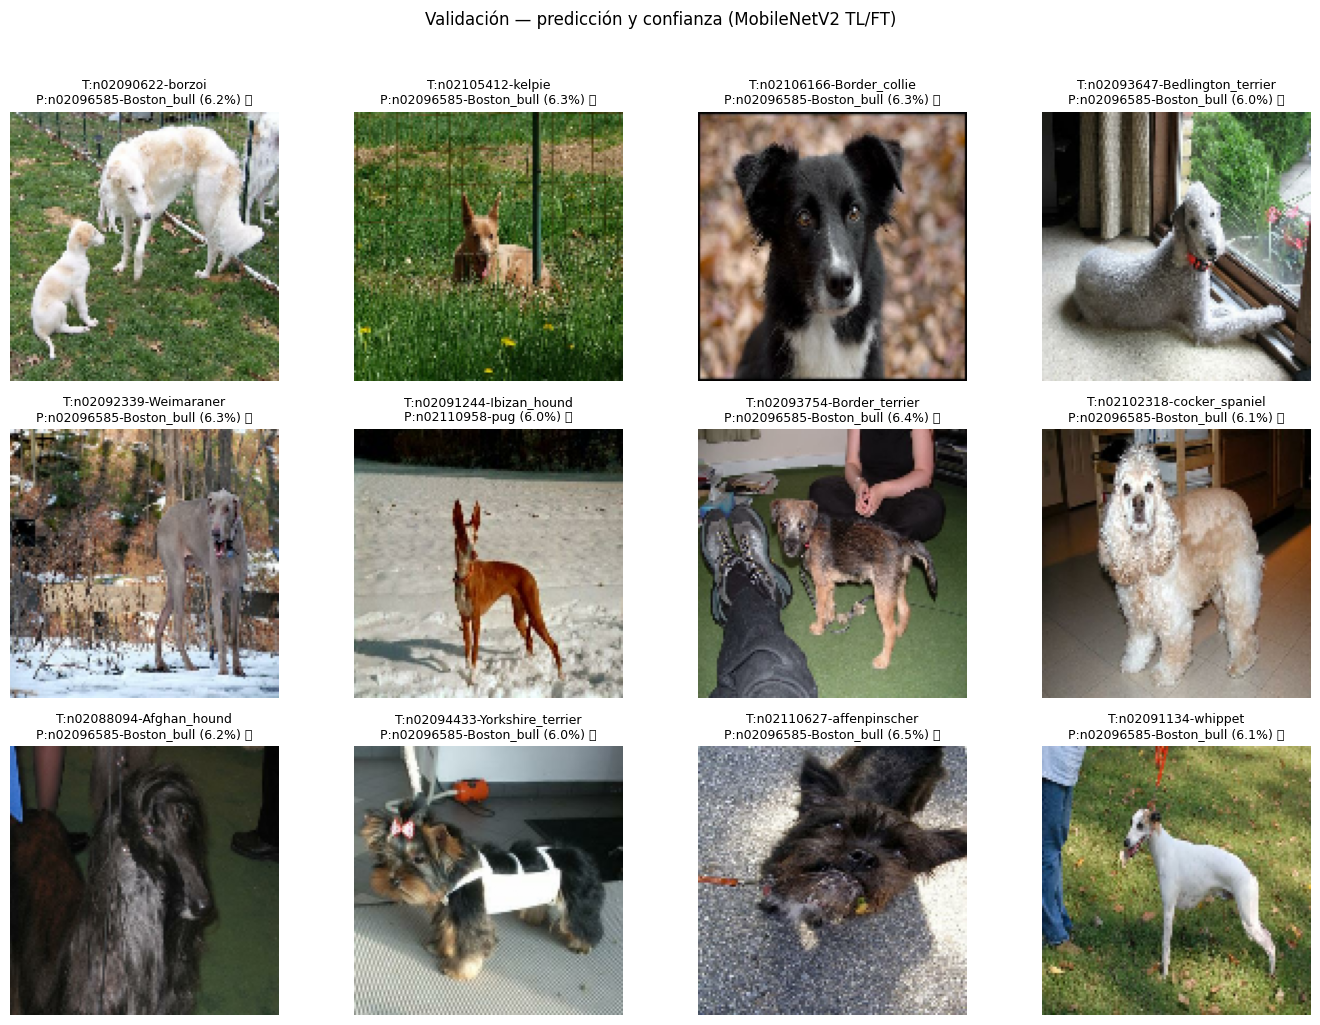

In [ ]:
# === Cuadrícula: imagen + predicción + confianza ===
import matplotlib.pyplot as plt

k = 12  # cuántas muestras graficar
imgs, labels = next(iter(val_img.unbatch().batch(k)))
probs = model_tl.predict(imgs, verbose=0)
preds = probs.argmax(axis=1)
conf  = probs.max(axis=1)

plt.figure(figsize=(14, 10))
for i in range(k):
    plt.subplot(3, 4, i+1)
    # asegúrate de mostrar en [0,1]
    plt.imshow(np.clip(imgs[i].numpy(), 0.0, 1.0))
    t = class_names[int(labels[i].numpy())]
    p = class_names[int(preds[i])]
    ok = "✅" if t == p else "❌"
    plt.title(f"T:{t}\nP:{p} ({conf[i]*100:.1f}%) {ok}", fontsize=9)
    plt.axis("off")
plt.suptitle("Validación — predicción y confianza (MobileNetV2 TL/FT)", y=1.02)
plt.tight_layout(); plt.show()
